In [886]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [887]:
# today's date string for file naming automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-03-07.csv'

print(today_date_str)

_2024-03-07.csv


In [888]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1645 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3029388743942.5767,USD,407.7000,USD,401.40,USD,4.14,USD,1.029620,-0.171603,7318938817.36,6038168,72897450,153732,18317632.3,22653584.93333334,24695687.58888889,1.521480,1.802997,1.456598,406.050000,36.87356987,Technology Services,1.33390343,0.9529795,1.0291758,0.8906199,0.006283,0.000648,0.102547,0.069518,0.511495,1.35116077,0.72525565,0.29577401,0.69349908,0.17078787,420.820,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,407.7700,USD,407.7840,USD,407.7840,USD,408.2100,USD,408.2100,USD,408.2100,USD,408.2100,USD,417.35,USD,417.35,USD,958891.40271493,USD,407.44680,407.458012,407.66144,406.709715,408.077949,407.557865,407.037781,408.834448,405.770310,402.706172
1,NVDA,NVIDIA Corporation,NASDAQ,2294911000000,USD,917.9644,USD,889.17,USD,14.55,USD,1.640361,0.244645,2399492500,24983933,196861538,963981,50731960.4,52039927.09999999,45684760.52222235,3.669561,3.465403,3.660522,911.288167,76.90398358,Electronic Technology,1.55029011,1.8023118,2.3419523,1.7245569,0.003040,0.000376,0.169068,0.108818,0.714603,1.8226155,0.93532542,0.43920408,0.87974948,0.24321959,919.880,USD,919.88,USD,919.88,USD,919.88,USD,919.88000,USD,917.7846,USD,918.6000,USD,918.6000,USD,919.8800,USD,919.8800,USD,919.8800,USD,919.8800,USD,919.88,USD,919.88,USD,2058175.67567568,USD,917.04892,917.041488,917.50708,914.952654,919.480428,917.509580,915.538732,922.645829,911.518965,900.392101
2,AMZN,"Amazon.com, Inc.",NASDAQ,1826433893442.8735,USD,175.8320,USD,172.50,USD,1.32,USD,0.760763,-0.582099,9227833763.2,10147300,116848089,216491,36604066.00000006,47647839.56666667,48387894.11111113,1.818962,1.727769,1.783302,175.407300,60.84994463,Retail Trade,1.18742275,1.1343786,1.3817025,1.1703976,0.002072,0.000255,0.231699,0.153234,0.740425,1.57087472,0.68843918,0.24672143,0.54233525,0.13228522,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.8100,USD,175.9699,USD,175.9699,USD,176.6699,USD,176.6699,USD,176.6699,USD,176.6699,USD,180.14,USD,180.14,USD,376908.19672131,USD,175.75702,175.806900,176.03200,175.929615,176.618810,176.080100,175.541390,177.031126,175.433745,173.836364
3,GOOGL,Alphabet Inc.,NASDAQ,1667862074561.7778,USD,133.6100

In [889]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [890]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.029389e+12,USD,407.7000,USD,401.40,USD,4.14,USD,1.029620,-0.171603,7318938817.36,6038168,72897450,153732,18317632.3,22653584.93333334,24695687.58888889,1.521480,1.802997,1.456598,406.050000,36.87356987,Technology Services,1.33390343,0.9529795,1.0291758,0.8906199,0.006283,0.000648,0.102547,0.069518,0.511495,1.35116077,0.72525565,0.29577401,0.69349908,0.17078787,420.820,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,407.7700,USD,407.7840,USD,407.7840,USD,408.2100,USD,408.2100,USD,408.2100,USD,408.2100,USD,417.35,USD,417.35,USD,958891.40271493,USD,407.44680,407.458012,407.66144,406.709715,408.077949,407.557865,407.037781,408.834448,405.770310,402.706172,Titans
1,NVDA,NVIDIA Corporation,NASDAQ,2.294911e+12,USD,917.9644,USD,889.17,USD,14.55,USD,1.640361,0.244645,2399492500,24983933,196861538,963981,50731960.4,52039927.09999999,45684760.52222235,3.669561,3.465403,3.660522,911.288167,76.90398358,Electronic Technology,1.55029011,1.8023118,2.3419523,1.7245569,0.003040,0.000376,0.169068,0.108818,0.714603,1.8226155,0.93532542,0.43920408,0.87974948,0.24321959,919.880,USD,919.88,USD,919.88,USD,919.88,USD,919.88000,USD,917.7846,USD,918.6000,USD,918.6000,USD,919.8800,USD,919.8800,USD,919.8800,USD,919.8800,USD,919.88,USD,919.88,USD,2058175.67567568,USD,917.04892,917.041488,917.50708,914.952654,919.480428,917.509580,915.538732,922.645829,911.518965,900.392101,Titans
2,AMZN,"Amazon.com, Inc.",NASDAQ,1.826434e+12,USD,175.8320,USD,172.50,USD,1.32,USD,0.760763,-0.582099,9227833763.2,10147300,116848089,216491,36604066.00000006,47647839.56666667,48387894.11111113,1.818962,1.727769,1.783302,175.407300,60.84994463,Retail Trade,1.18742275,1.1343786,1.3817025,1.1703976,0.002072,0.000255,0.231699,0.153234,0.740425,1.57087472,0.68843918,0.24672143,0.54233525,0.13228522,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.8100,USD,175.9699,USD,175.9699,USD,176.6699,USD,176.6699,USD,176.6699,USD,176.6699,USD,180.14,USD,180.14,USD,376908.19672131,USD,175.75702,175.806900,176.03200,175.929615,176.618810,176.080100,175.541390,177.031126,175.433745,173.836364,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.667862e

In [891]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [892]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1645 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,377,22.917933
1,Large caps,370,22.492401
2,Midlers,316,19.209726
3,Shrimp,277,16.838906
4,Micro caps,250,15.197568
5,Titans,40,2.431611
6,Undefined,15,0.911854


In [893]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1630 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
864,BCYC,Bicycle Therapeutics plc,NASDAQ,1.045519e+09,USD,25.0650,USD,26.0000,USD,1.3600,USD,5.519481,5.519481,41926912.848132,95547,1476211,500,366916.9,385478.6,487122.53333333,2.603743,5.411753,6.280288,24.955000,-,Health Technology,2.98542246,1.5539886,1.8239945,0.89322513,0.029442,0.016485,3.374216,3.449856,2.164873,4.00094382,1.83039267,0.24030519,0.92366933,0.23189298,27.2400,USD,27.240,USD,27.240000,USD,28.910000,USD,62.075000,USD,25.0650,USD,25.10,USD,25.10,USD,25.10,USD,25.220,USD,25.220,USD,25.220,USD,25.800,USD,26.3300,USD,95354.0876986,USD,25.01300,24.990625,24.97900,24.940000,25.171392,24.817810,24.464228,25.284279,24.881500,24.478721,Small caps
762,SGML,Sigma Lithium Corporation,NASDAQ,1.634835e+09,USD,14.9300,USD,15.2600,USD,0.1400,USD,0.926539,0.992720,45231822,263463,4158013,5832,1639746.3,1776773.53333333,1380712.34444444,6.916525,9.148273,9.987203,15.098333,-,Non-Energy Minerals,0.56511907,1.7073392,0.49892375,0.56932527,0.416947,0.814125,0.208721,0.162607,0.617642,0.99585371,0.31935777,0.15050254,0.60848242,0.30046754,16.3600,USD,34.305,USD,39.380000,USD,43.180000,USD,43.180000,USD,14.9900,USD,14.99,USD,14.99,USD,14.99,USD,15.690,USD,15.690,USD,15.690,USD,16.360,USD,16.3600,USD,0,USD,14.96700,14.915625,14.83500,14.848346,14.998745,14.844000,14.689255,15.513217,15.007175,14.501133,Small caps
1422,SOLO,Electrameccanica Vehicles Corp. Ltd.,NASDAQ,2.742526e+07,USD,0.2299,USD,0.2400,USD,0.0009,USD,0.389610,3.896104,113605231.06799997,156369,1784819,5238,500706.5,430437.66666667,517120.37777778,4.444444,6.989146,6.097033,0.229967,-,Consumer Durables,1.00861328,2.8385837,1.8345082,2.596854,0.299850,0.081352,0.014618,0.006828,0.293061,1.44773586,0.53363647,0.30813732,0.69116933,0.18426855,0.2732,USD,0.400,USD,0.740000,USD,1.040000,USD,16.000000,USD,0.2300,USD,0.23,USD,0.23,USD,0.23,USD,0.235,USD,0.235,USD,0.235,USD,0.251,USD,0.2596,USD,64880.43809534,USD,0.22998,0.229988,0.22894,0.228742,0.231471,0.229243,0.227015,0.232071,0.228677,0.225283,Shrimp
1616,ZVSA,"ZyVersa Therapeutics, Inc.",NASDAQ,1.577729e+06,USD,0.9601,USD,0.8135,USD,0.0011,USD,0.143062,5.800494,1600520.335793,901133,3677237,60272,12314835.4,44

In [894]:
# # drop undefined
# tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

# market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

# market_cap_type_df2
# print(market_cap_type_df2)


In [895]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [896]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1630
Number of rows removed: 1626
NEW DataFrame length: 4


In [897]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Large caps,1,25.0
1,Midlers,1,25.0
2,Small caps,1,25.0
3,Shrimp,1,25.0


In [898]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Large caps' 'Midlers' 'Small caps' 'Shrimp']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'R

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,AGR,"Avangrid, Inc.",NYSE,1.398403e+10,USD,36.1550,USD,33.60,USD,3.72,USD,11.596010,4.738155,6.853858e+07,2556937,4898242,162256,890896.7,799781.7,923876.26666667,11.818182,2.209133,2.215244,36.070000,17.80859029,Utilities,44.310116,0.89043146,0.7404226,0.54155004,0.008215,0.001919,0.466285,0.451788,1.195366,19.27370505,11.25233605,3.305672,1.44226988,0.31088383,36.3050,USD,36.3050,USD,36.3050,USD,41.2200,USD,57.240,USD,36.1500,USD,36.1750,USD,36.1750,USD,36.3050,USD,36.3050,USD,36.3050,USD,36.3050,USD,36.3050,USD,36.3050,USD,1040005.00062508,USD,36.15900,36.161250,36.17500,36.169231,36.240054,36.173250,36.106446,36.284194,36.121300,35.958406,Large caps
1,ARHS,"Arhaus, Inc.",NASDAQ,2.100035e+09,USD,14.9700,USD,13.41,USD,1.18,USD,9.204368,4.602184,3.849788e+07,1844451,5509621,18588,886492.2,729934.2,905800.26666667,20.072464,6.089707,3.844914,14.786667,14.85413773,Consumer Durables,21.535353,2.1525056,2.3993912,2.3993912,0.034688,0.008684,0.187786,0.159855,0.742167,6.67563224,4.8590718,2.410472,1.59420442,0.34527383,15.5900,USD,15.5900,USD,15.5900,USD,15.5900,USD,15.590,USD,14.9800,USD,15.1100,USD,15.1100,USD,15.1400,USD,15.5900,USD,15.5900,USD,15.5900,USD,15.5900,USD,15.5900,USD,579683.01886792,USD,15.02900,15.020625,14.95300,14.964377,15.121820,14.952750,14.783680,15.263195,14.929125,14.595055,Midlers
2,ML,MoneyLion Inc.,NYSE,7.195275e+08,USD,69.9800,USD,53.84,USD,9.45,USD,17.982873,2.454805,4.834745e+06,336986,791941,16874,128262.4,113884.2,133646.32222222,31.351256,9.312434,6.593099,66.417467,-,Technology Services,12.848809,2.4364288,3.0196884,2.6366432,0.047272,0.013522,0.312359,0.280489,1.454853,10.71768588,6.43124759,3.300665,1.26885093,0.45998353,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,387.387,USD,70.1300,USD,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,70.8623,USD,503316.10044313,USD,70.15236,70.327675,69.68292,68.237277,71.266676,69.390585,67.514494,72.638218,66.512145,60.386072,Small caps
3,LYT,Lytus Technologies Holdings PTV. Ltd.,NASDAQ,3.606651e+06,USD,13.5074,USD,6.96,USD,7.14,USD,309.090909,201.298701,3.210263e+05,37786097,42444620,5882429,4454003.6,1607600.

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [899]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [900]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [901]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [902]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 4/4 [00:00<00:00, 1082.19it/s]


In [903]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2023-10-16
END date: 2024-03-13
103 days of historical stock data.

412 = Length of dataframe
4 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['AGR', 'ARHS', 'ML', 'LYT']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
402,2.660,2.7599,2.6000,2.650,2024-02-29,LYT,53493.0,HISTORICAL_PRICES,LYT,,2024-02-29,1709258432000,13.000000,13.000000,2.650,2.660,2.7599,2.6000,53493,2.650,2.660,2.7599,2.6000,53493.0,"Feb 29, 24",-0.030,-0.0112,LYT
403,3.100,3.6600,2.5611,2.690,2024-03-01,LYT,973024.0,HISTORICAL_PRICES,LYT,,2024-03-01,1709350226000,15.315789,15.315789,2.690,3.100,3.6600,2.5611,973024,2.690,3.100,3.6600,2.5611,973024.0,"Mar 1, 24",0.440,0.1654,LYT
404,2.625,3.0700,2.6100,2.940,2024-03-04,LYT,109899.0,HISTORICAL_PRICES,LYT,,2024-03-04,1709604060000,12.815789,12.815789,2.940,2.625,3.0700,2.6100,109899,2.940,2.625,3.0700,2.6100,109899.0,"Mar 4, 24",-0.475,-0.1532,LYT
405,2.430,2.6300,2.2200,2.440,2024-03-05,LYT,113900.0,HISTORICAL_PRICES,LYT,,2024-03-05,1709692307000,11.789474,11.789474,2.440,2.430,2.6300,2.2200,113900,2.440,2.430,2.6300,2.2200,113900.0,"Mar 5, 24",-0.195,-0.0743,LYT
406,2.310,2.5000,2.2600,2.370,2024-03-06,LYT,4434724.0,HISTORICAL_PRICES,LYT,,2024-03-06,1709776870000,11.157895,11.157895,2.370,2.310,2.5000,2.2600,4434724,2.370,2.310,2.5000,2.2600,4434724.0,"Mar 6, 24",-0.120,-0.0494,LYT
407,8.700,18.6216,8.0500,9.516,2024-03-07,LYT,75316515.0,HISTORICAL_PRICES,LYT,,2024-03-07,1709863229000,44.789474,44.789474,9.516,8.700,18.6216,8.0500,75316515,9.516,8.700,18.6216,8.0500,75316515.0,"Mar 7, 24",6.390,2.7662,LYT
408,8.000,9.4000,6.9548,8.240,2024-03-08,LYT,3639833.0,HISTORICAL_PRICES,LYT,,2024-03-08,1709951485000,41.105263,41.105263,8.240,8.000,9.4000,6.9548,3639833,8.240,8.000,9.4000,6.9548,3639833.0,"Mar 8, 24",-0.700,-0.0805,LYT
409,6.380,8.0000,6.1601,7.140,2024-03-11,LYT,973125.0,HISTORICAL_PRICES,LYT,,2024-03-11,1710230463000,32.578947,32.578947,7.140,6.380,8.0000,6.1601,973125,7.140,6.380,8.0000,6.1601,973125.0,"Mar 11, 24",-1.620,-0.2025,LYT
410,5.030,6.5992,4.5739,6.380,2024-03-12,LYT,580287.0,HISTORICAL_PRICES,LYT,,2024-03-12,1710297017000,25.473684,25.473684,6.380,5.030,6.5992,4.5739,580287,6.380,5.030,6.5992,4.5739,580287.0,"Mar 12, 24",-1.350,-0.2116,LYT
411,4.950,5.9600,4.5800,4.940,2024-03-13,LYT,719521.0,HISTORICAL_PRICES,LYT,,2024-03-13,1710381608000,25.052632,25.052632,4.940,4.950,5.9600,4.5800,719521,4.940,4.950,5.9600,4.5800,719521.0,"Mar 13, 24",-0.080,-0.0159,LYT


In [904]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [905]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,AGR,2024-03-13,35.58,36.02,35.310,35.88,1830287.0
1,ARHS,2024-03-13,16.02,16.43,15.205,15.21,1949483.0
2,LYT,2024-03-13,4.95,5.96,4.580,4.94,719521.0
3,ML,2024-03-13,73.00,75.84,65.000,65.44,386136.0


In [906]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 412


In [907]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [908]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,AGR,2023-10-16,31.38,31.610,30.8300,31.170,1029374.0
206,ML,2023-10-16,21.59,21.730,20.1800,20.230,62697.0
309,LYT,2023-10-16,0.19,0.190,0.1676,0.175,638768.0
103,ARHS,2023-10-16,9.71,9.735,9.4000,9.520,390381.0
1,AGR,2023-10-17,31.42,31.800,31.0500,31.050,1354796.0


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [909]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2023-10-16,AGR,31.38,31.610,30.8300,31.170,1029374.0
2023-10-16,ML,21.59,21.730,20.1800,20.230,62697.0
2023-10-16,LYT,0.19,0.190,0.1676,0.175,638768.0
2023-10-16,ARHS,9.71,9.735,9.4000,9.520,390381.0
2023-10-17,AGR,31.42,31.800,31.0500,31.050,1354796.0


| TICKER - Unit TESTING | 
|-|

In [920]:
# filter by symbol
ticker = 'ML'
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

# dtype of index
print(ticker_df.index.dtype)

ticker_df.tail(10)

datetime64[ns]


,symbol,close,high,low,open,volume
date,,,,,,
2024-02-29,ML,50.04,51.3818,49.7800,50.12,59222.0
2024-03-01,ML,51.86,51.8600,48.6100,50.57,121219.0
2024-03-04,ML,50.06,52.8238,49.0301,52.25,96727.0
2024-03-05,ML,50.28,52.6700,49.5800,49.69,166085.0
2024-03-06,ML,52.55,52.6600,50.3500,51.11,192143.0
2024-03-07,ML,67.36,70.8623,58.4101,59.46,764686.0
2024-03-08,ML,74.49,75.7400,65.5000,69.09,395372.0
2024-03-11,ML,64.59,74.7700,59.2500,73.00,507613.0
2024-03-12,ML,65.68,65.6900,62.0000,65.27,366334.0


In [921]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-02-29,ML,50.04,51.3818,49.7800,50.12,59222.0
2024-03-01,ML,51.86,51.8600,48.6100,50.57,121219.0
2024-03-04,ML,50.06,52.8238,49.0301,52.25,96727.0
2024-03-05,ML,50.28,52.6700,49.5800,49.69,166085.0
2024-03-06,ML,52.55,52.6600,50.3500,51.11,192143.0
2024-03-07,ML,67.36,70.8623,58.4101,59.46,764686.0
2024-03-08,ML,74.49,75.7400,65.5000,69.09,395372.0
2024-03-11,ML,64.59,74.7700,59.2500,73.00,507613.0
2024-03-12,ML,65.68,65.6900,62.0000,65.27,366334.0


| DATA PACKAGE |
|-|
| Technical Indicators |


In [922]:
# Step 1: Extract the last 72 closing prices
last_72_df = ticker_df[['Close']].tail(72)
last_72_df['Index'] = np.arange(len(ticker_df) - 72, len(ticker_df))

In [923]:
# Step 2: Perform a linear regression
X = last_72_df['Index'].values.reshape(-1, 1)  # Reshape for scikit-learn
y = last_72_df['Close'].values
model = LinearRegression().fit(X, y)

In [924]:
# Step 3: Calculate the y-values for the line of best fit for the last 72 periods
best_fit_last_72 = model.predict(X)

# Create a series for the best fit line, filled with NaN except for the last 72 values
best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
best_fit_series[-72:] = best_fit_last_72

# Find the pivot point within the last 72 periods: the lowest closing price
pivot_point_index = last_72_df['Close'].idxmin()
pivot_point_value = last_72_df.loc[pivot_point_index, 'Close']

# Create a series for the pivot point, similar to the best fit line
pivot_points = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
pivot_points[pivot_point_index] = pivot_point_value

# Plot setup
apds = [mpf.make_addplot(best_fit_series, color='orange', width=2),
        mpf.make_addplot(pivot_points, type='scatter', markersize=200, marker='x', color='red')]

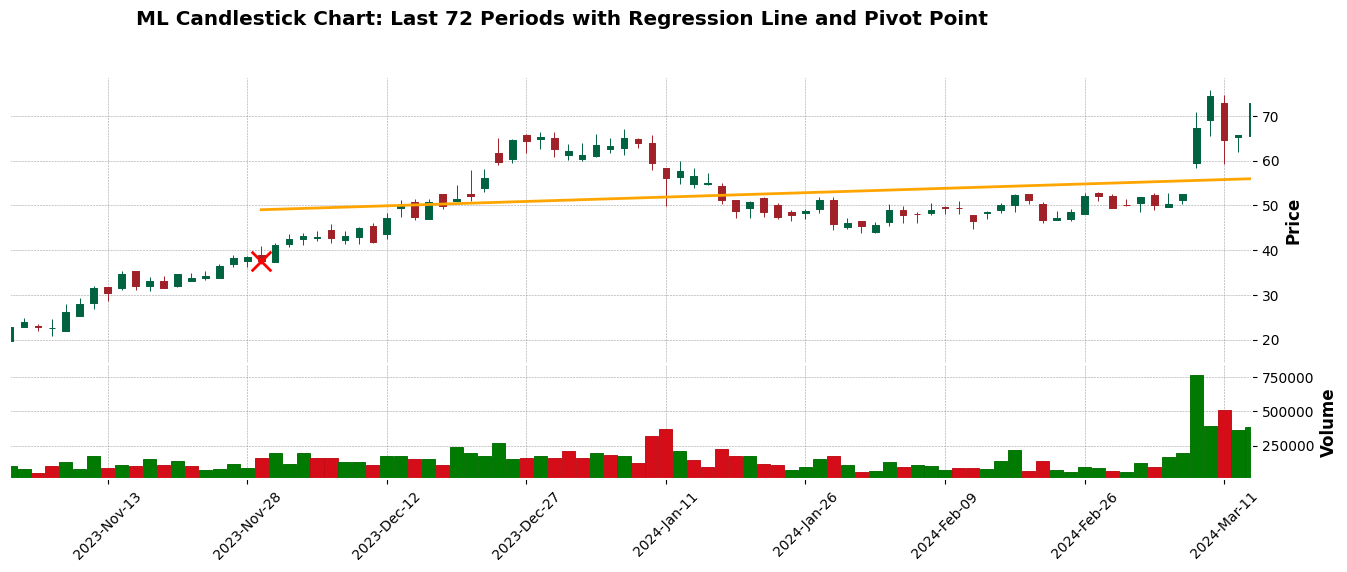

In [925]:
# Step 4: chart data
last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
         figratio=(42, 14),
         xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
         addplot=apds)

mpf.show()


| Dataframe -> .csv file |
|-|

In [ ]:
# create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
ticker_csv_df = ticker_df.reset_index()
# dtype of date
print(ticker_csv_df['date'].dtype)
# print index type
print(ticker_csv_df.index.dtype)

# save to csv
ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

ticker_csv_df.head(2)


datetime64[ns]
int64


,date,symbol,Close,High,Low,Open,Volume,Index,BestFit,Residuals
0,2023-10-16,PPC,24.27,24.380,23.78,24.06,661824,0,4.995732,19.274268
1,2023-10-17,PPC,24.47,24.885,24.27,24.35,1136326,1,5.277275,19.192725


In [ ]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [ ]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [ ]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [ ]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [ ]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [ ]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [ ]:
# chart_historical_df.head(5)

In [ ]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [ ]:
# # date column check data type
# chart_historical_df.index

In [ ]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [ ]:
# chart_historical_df.index

In [ ]:
# chart_historical_df.head(5)

In [ ]:
# print(tv_L2_df.columns)

In [ ]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [ ]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [ ]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [ ]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [ ]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [ ]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [ ]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [ ]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [ ]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [ ]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [ ]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [ ]:
# # check the date column type
# chart_historical_df.index

In [ ]:
# print(f'Unique stock symbols: {unique_symbols}')

In [ ]:
# tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
# tl_pre_df = tl_pre_df.iloc[:,:6]

# tl_pre_df.head(5)

In [ ]:
# # get the date column type
# tl_pre_df.index

In [ ]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [ ]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)